## N01 - Point Cloud Representation of Jets

### Load dataset

- The [R&D Dataset](https://zenodo.org/record/4536377) for LHC Olympics 2020 Anomaly Detection Challenge
- A total of 100k signal ($W'\rightarrow XY$) and 1M QCD dijet background events
- The signals are generated with $W'$ mass = 3.5 TeV, $X$ mass = 500 GeV and $Y$ mass = 100 GeV
- The first 3 * 700 = 2100 columns are the $p_T$, $\eta$ and $\phi$ of the constituent particles (up to 700 of them, zero padded)
- The last column is the class label (0 = background, 1 = signal)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for nojit
import numba as nb

# for awkward arrays
import awkward as ak
import vector
vector.register_awkward()
# for jet clustering (old method)
import pyjet as pj
from pyjet import cluster, DTYPE_PTEPM
# for jet clustering (new method)
#import fastjet as fj

proj_dir = "/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/"

# print library versions
print(f'awkward version: {ak.__version__}')
print(f'vector version: {vector.__version__}')
print(f'pyjet version: {pj.__version__}')

awkward version: 2.4.5
vector version: 1.1.1.post1
pyjet version: 1.9.0


In [2]:
input_path = os.path.join(proj_dir, "events_anomalydetection.h5")
df = pd.read_hdf(input_path)

In [3]:
# just to make sure it is the same file from zenodo
!md5sum {input_path}

a06c71ae36cbd4de6699a490c06b94b7  /global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5


In [4]:
print(f'Number of events: {df.shape[0]}')
df.head()

Number of events: 1100000


,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,0.324101,-0.361158,2.737669,0.409859,-2.429939,0.729830,0.867922,-2.267777,-1.161310,0.383031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.646304,-0.539460,-1.386258,0.471293,-1.636572,0.751657,0.453769,-1.099593,-0.393405,0.485929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.325172,-0.833948,2.404844,1.295058,-2.089618,-1.873342,0.451272,-0.101877,2.217348,0.461293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.290918,-2.200063,1.630132,0.565028,-1.714345,-2.617103,0.951042,-0.532720,2.941473,0.896248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.526330,-2.349110,-1.745532,0.542491,-2.080352,-3.044045,0.390727,-1.278563,-2.131058,2.530358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
# check that there are 1M background and 100k signal events
print(f'Number of signal events     : {(df[2100] == 1).sum():,}')
print(f'Number of background events : {(df[2100] == 0).sum():,}')

Number of signal events     : 100,000
Number of background events : 1,000,000


### Jet Clustering

In [6]:
import numba

@nb.njit()
def get_jet_consituents_array(data):
    pt_indices = np.arange(700) * 3
    # check index of the first particle to have zero pt
    last_indices = np.argmax(data[:, pt_indices] == 0, axis=1)
    arrays = []
    nevent = data.shape[0]
    for i in range(nevent):
        nparticle = last_indices[i]
        array = np.zeros(nparticle, dtype=DTYPE_PTEPM)
        for j in range(nparticle):
            array[j]['pT']  = data[i][j * 3]
            array[j]['eta'] = data[i][j * 3 + 1]
            array[j]['phi'] = data[i][j * 3 + 2]
        arrays.append(array)
    return arrays
    
def get_jet_cluster(array):
    sequence = cluster(array, R=1.0, p=-1)
    jets = sequence.inclusive_jets(ptmin=20)
    return jets

# method to build structured awkward arrays
@nb.njit
def build_array(builder, events):
    for event in events:
        builder.begin_list()
        for particle in event:
            builder.begin_record("Momentum4D")
            builder.field("pt").real(particle[0])
            builder.field("eta").real(particle[1])
            builder.field("phi").real(particle[2])
            builder.field("m").real(particle[3])
            builder.end_record()
        builder.end_list()
    return builder

def get_jet_data(events):
    return [np.array([[j.pt, j.eta, j.phi, j.mass] for j in jets]) for jets in events]

def get_ak_array(events):
    return build_array(ak.ArrayBuilder(), numba.typed.List(events)).snapshot()

In [7]:
jet_constituents = {
    "signal"     : get_jet_consituents_array(df[df[2100] == 1].values),
    "background" : get_jet_consituents_array(df[df[2100] == 0].values)
}

In [8]:
# first event, first 5 particles
jet_constituents["signal"][0][:5]

array([(0.52632993, -2.34910965, -1.74553227, 0.),
       (0.5424912 , -2.08035183, -3.04404473, 0.),
       (0.39072677, -1.27856314, -2.13105845, 0.),
       (2.53035808, -2.12442136, -3.08277678, 0.),
       (0.51176298, -1.8190223 , -0.50227135, 0.)],
      dtype=[('pT', '<f8'), ('eta', '<f8'), ('phi', '<f8'), ('mass', '<f8')])

### Extract jet clusters

In [9]:
# need to process in batches due to high memory demand

save_dir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/"
save_path = {
    "signal"     : os.path.join(save_dir, "signal_clustered_{obj}_100k_events_batch_{i}.parquet"),
    "background" : os.path.join(save_dir, "background_clustered_{obj}_1M_events_batch_{i}.parquet")
}

batchsize = 100000
# maximum number of jets to save the constituent information
max_jet = 4
cache = True
all_jets = {}
all_constituents = {}
for dtype in ["signal", "background"]:
    all_jets[dtype] = []
    all_constituents[dtype] = {}
    for j in range(max_jet):
        all_constituents[dtype][f'j{j+1}'] = []
    # assume divisible
    nbatch = len(jet_constituents[dtype]) // batchsize
    for i in range(nbatch):
        i_start = i * batchsize
        i_end  = max((i+1)*batchsize, nbatch)
        path_jets = save_path[dtype].format(i=i+1, obj="jets")
        paths_constituents = []
        for j in range(max_jet):
            path_constituents = save_path[dtype].format(i=i+1, obj=f"constituents_jet_{j+1}")
            paths_constituents.append(path_constituents)
        # only do jet clustering if not cached
        if os.path.exists(path_jets) and all([os.path.exists(path) for path in paths_constituents]) and cache:
            jets_batch = None
        else:
            print(f'Creating clustered jet data for "{dtype}" (batch {i+1} / {nbatch})')
            jets_batch = [get_jet_cluster(constituents) for constituents in jet_constituents[dtype][i_start: i_end]]
        # convert to awkward array
        if os.path.exists(path_jets) and cache:
            print(f'Cached existing clustered jet data from "{path_jets}"')
            jet_array = ak.from_parquet(path_jets)
        else:
            print(f'Converting clustered jet data to awkward arrays')
            jet_array = get_ak_array(get_jet_data(jets_batch))
            if cache:
                print(f'Saving clustered jet data to "{path_jets}"')
                ak.to_parquet(jet_array, path_jets)
        all_jets[dtype].append(jet_array)
        for j in range(max_jet):
            path_constituents = paths_constituents[j]
            if os.path.exists(path_constituents) and cache:
                print(f'Cached existing clustered jet constituents data from "{path_constituents}"')
                constituent_array = ak.from_parquet(path_constituents)
            else:
                print(f'Creating clustered jet constituents data for "{dtype}" (jet {j + 1})')
                constituent_jet_j = [jets[j].constituents_array() if len(jets) > j else np.array([], dtype=DTYPE_PTEPM) \
                                     for jets in jets_batch ]
                constituent_array = get_ak_array(constituent_jet_j)
                if cache:
                    print(f'Saving clustered jet constituents data to "{path_constituents}"')
                    ak.to_parquet(constituent_array, path_constituents)
            all_constituents[dtype][f'j{j+1}'].append(constituent_array)
    all_jets[dtype] = ak.concatenate(all_jets[dtype])
    for j in range(max_jet):
        all_constituents[dtype][f'j{j+1}'] = ak.concatenate(all_constituents[dtype][f'j{j+1}'])

Cached existing clustered jet data from "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/signal_clustered_jets_100k_events_batch_1.parquet"
Cached existing clustered jet constituents data from "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/signal_clustered_constituents_jet_1_100k_events_batch_1.parquet"
Cached existing clustered jet constituents data from "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/signal_clustered_constituents_jet_2_100k_events_batch_1.parquet"
Cached existing clustered jet constituents data from "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/signal_clustered_constituents_jet_3_100k_events_batch_1.parquet"
Cached existing clustered jet constituents data from "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/signal_clustered_constituents_jet_4_100k_events_batch_1.parquet"
Cached existing clustered jet data from "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/L

In [20]:
# save the combined data
save_path = {
    "signal"     : os.path.join(save_dir, "signal_clustered_{obj}_100k_events.parquet"),
    "background" : os.path.join(save_dir, "background_clustered_{obj}_1M_events.parquet")
}
for dtype in ['signal', 'background']:
    ak.to_parquet(all_jets[dtype], save_path[dtype].format(obj='jets'))
    for j in range(max_jet):
        ak.to_parquet(all_jets[dtype], save_path[dtype].format(obj=f'constituents_jet_{j+1}'))

In [10]:
print('Jets from first signal event:\n')
all_jets['signal'][0]

Jets from first signal event:



<MomentumArray4D [{pt: 1.21e+03, eta: -0.745, ...}, ...] type='4 * Momentum...'>

In [11]:
print('constituent from leading jet of first signal event:\n')
all_constituents['signal']['j1'][0]

constituent from leading jet of first signal event:



<MomentumArray4D [{pt: 1.71, eta: -1.66, ...}, ...] type='54 * Momentum4D[p...'>

In [12]:
print('Jets from first background event:\n')
all_jets['background'][0]

Jets from first background event:



<MomentumArray4D [{pt: 1.29e+03, eta: 0.186, ...}, ...] type='2 * Momentum4...'>

In [13]:
print('constituent from leading jet of first background event:\n')
all_constituents['background']['j1'][0]

constituent from leading jet of first background event:



<MomentumArray4D [{pt: 1.11, eta: 0.216, ...}, ...] type='36 * Momentum4D[p...'>

### Prepare features for training


Particle-level features

- $p_T$, $p_T^\text{rel}$
- $\eta$, $\Delta \eta$
- $\phi$, $\Delta \phi$
- $\Delta R$

Jet-level features

- $p_T$
- $\eta$
- $\phi$
- $m$
- $N_{\text{particle}}$

In [14]:
all_jets['signal'][8]

<MomentumArray4D [{pt: 1.5e+03, eta: -0.34, ...}, ...] type='4 * Momentum4D...'>

In [15]:
features = {}
for dtype in ["signal", "background"]:
    features[dtype] = {}
    for key in all_constituents[dtype]:
        features[dtype][key] = {}
        # jet features
        jet_p4 = ak.sum(all_constituents[dtype][key], axis=-1)
        features[dtype][key]["jet_pt"]   = jet_p4.pt
        features[dtype][key]["jet_eta"]  = jet_p4.eta
        features[dtype][key]["jet_phi"]  = jet_p4.phi
        features[dtype][key]["jet_m"]    = jet_p4.m
        features[dtype][key]["N"]        = ak.count(all_constituents[dtype][key], axis=-1)
        # particle features
        features[dtype][key]['part_pt']        = all_constituents[dtype][key].pt
        features[dtype][key]['part_eta']       = all_constituents[dtype][key].eta
        features[dtype][key]['part_phi']       = all_constituents[dtype][key].phi
        features[dtype][key]['part_m']         = all_constituents[dtype][key].m
        features[dtype][key]['part_rel_pt']    = all_constituents[dtype][key].pt / jet_p4.pt
        features[dtype][key]['part_delta_eta'] = all_constituents[dtype][key].deltaeta(jet_p4)
        features[dtype][key]['part_delta_phi'] = all_constituents[dtype][key].deltaphi(jet_p4)
        features[dtype][key]['part_delta_R']   = all_constituents[dtype][key].deltaR(jet_p4)

In [108]:
# save features
features_array = ak.Record(features)
save_path = os.path.join(save_dir, "point_cloud_features_signal_plus_background.parquet")
ak.to_parquet(features_array, save_path)

  created_by: parquet-cpp-arrow version 13.0.0
  num_columns: 104
  num_rows: 1
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

## Visualization

In [17]:
# load back saved features
save_path = os.path.join(save_dir, "point_cloud_features_signal_plus_background.parquet")
features_array = ak.from_parquet(save_path)

In [18]:
from quickstats.plots import VariableDistributionPlot

In [19]:
dfs = {}
for dtype in ["signal", "background"]:
    data = {
        "lead_jet_pt"  : np.array(features_array[dtype]["j1"]["jet_pt"]),
        "lead_jet_eta" : np.array(features_array[dtype]["j1"]["jet_eta"]),
        "lead_jet_phi" : np.array(features_array[dtype]["j1"]["jet_phi"]),
        "lead_jet_m"   : np.array(features_array[dtype]["j1"]["jet_m"]),
        "lead_jet_N"   : np.array(features_array[dtype]["j1"]["N"]),
        "sub_jet_pt"  : np.array(features_array[dtype]["j2"]["jet_pt"]),
        "sub_jet_eta" : np.array(features_array[dtype]["j2"]["jet_eta"]),
        "sub_jet_phi" : np.array(features_array[dtype]["j2"]["jet_phi"]),
        "sub_jet_m"   : np.array(features_array[dtype]["j2"]["jet_m"]),
        "sub_jet_N"   : np.array(features_array[dtype]["j2"]["N"]),
    }
    # calculate mjj
    j1_p4 = ak.zip({
    "pt"  : features_array[dtype]["j1"]["jet_pt"],
    "eta" : features_array[dtype]["j1"]["jet_eta"],
    "phi" : features_array[dtype]["j1"]["jet_phi"],
    "m"   : features_array[dtype]["j1"]["jet_m"]
    }, with_name="Momentum4D")
    j2_p4 = ak.zip({
        "pt"  : features_array[dtype]["j2"]["jet_pt"],
        "eta" : features_array[dtype]["j2"]["jet_eta"],
        "phi" : features_array[dtype]["j2"]["jet_phi"],
        "m"   : features_array[dtype]["j2"]["jet_m"]
    }, with_name="Momentum4D")
    jj_p4 =j1_p4.add(j2_p4)
    data['mjj'] = np.array(jj_p4.m)
    dfs[dtype] = pd.DataFrame(data)

<Figure size 640x480 with 0 Axes>

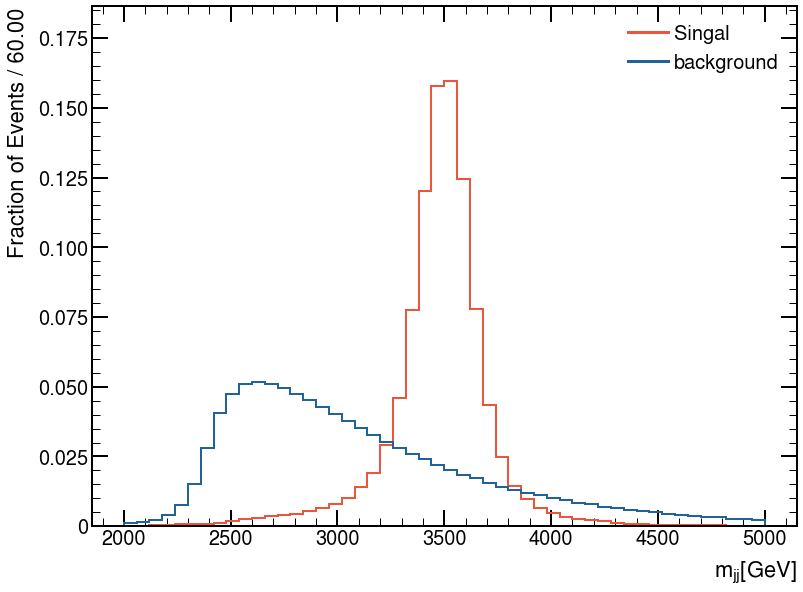

<Figure size 640x480 with 0 Axes>

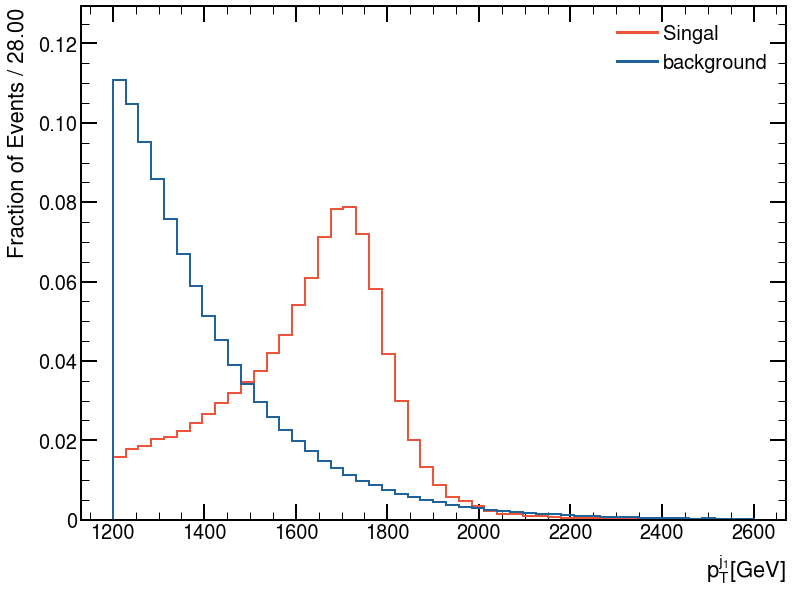

<Figure size 640x480 with 0 Axes>

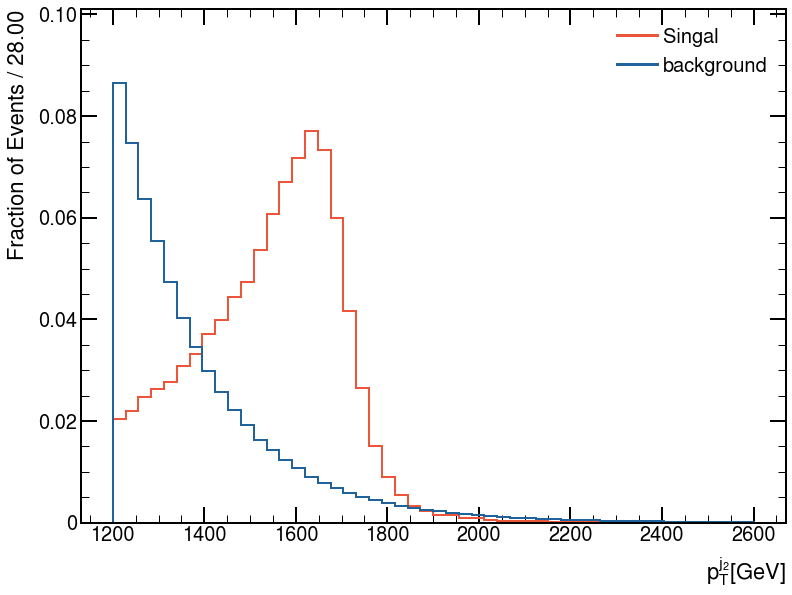

<Figure size 640x480 with 0 Axes>

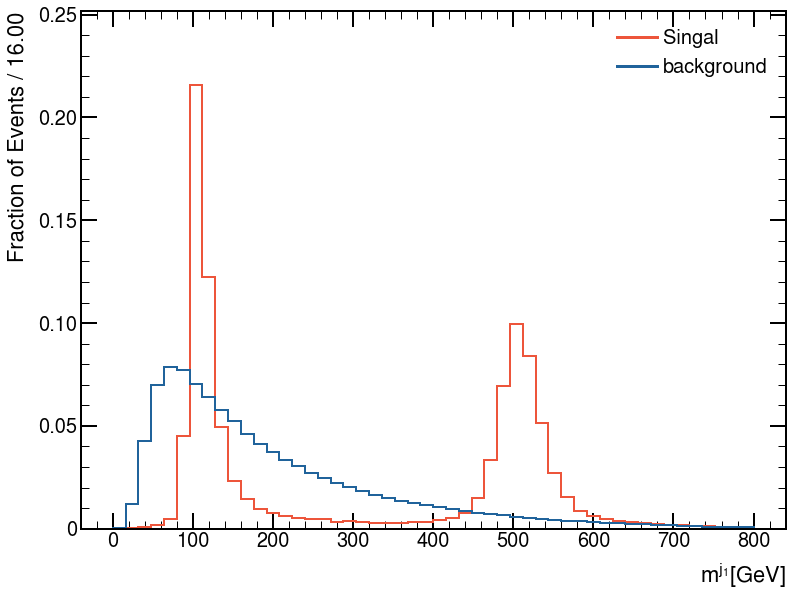

<Figure size 640x480 with 0 Axes>

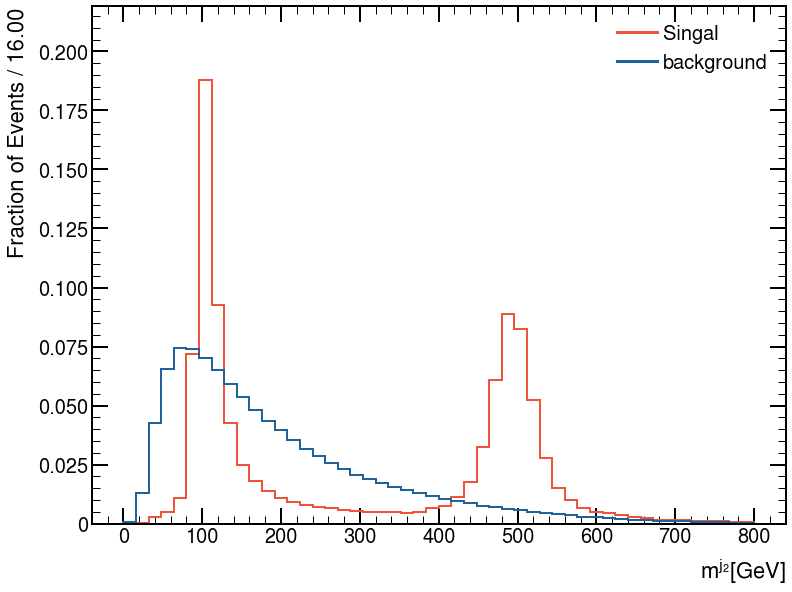

[INFO] Using deduced bin range (-2.263, 1.980)


<Figure size 640x480 with 0 Axes>

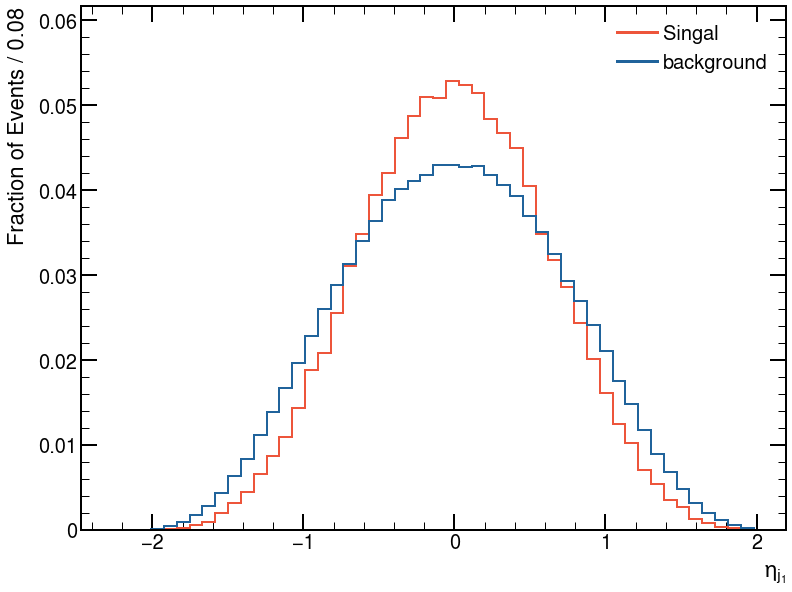

[INFO] Using deduced bin range (-2.428, 2.153)


<Figure size 640x480 with 0 Axes>

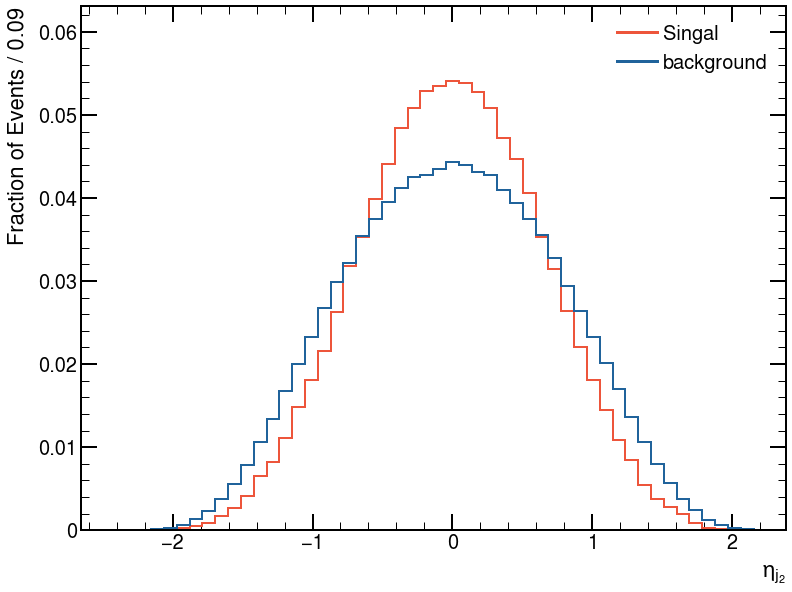

[INFO] Using deduced bin range (-3.142, 3.141)


<Figure size 640x480 with 0 Axes>

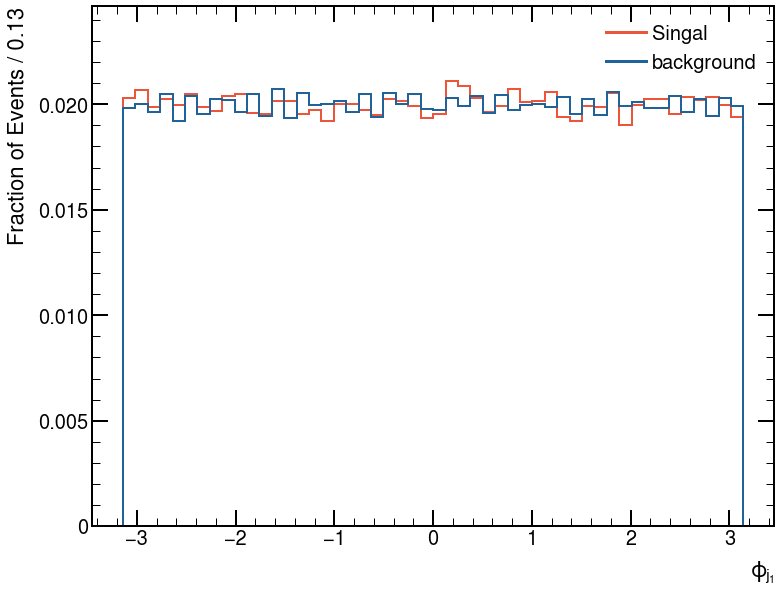

[INFO] Using deduced bin range (-3.142, 3.142)


<Figure size 640x480 with 0 Axes>

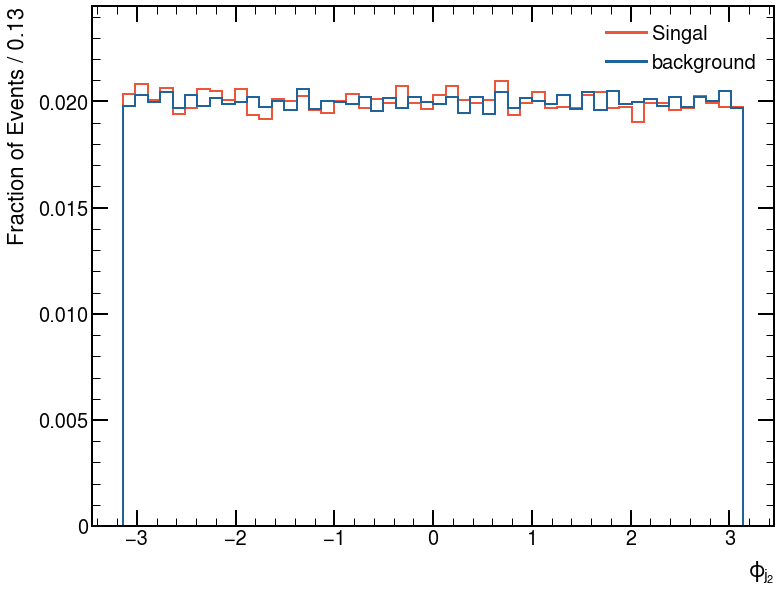

[INFO] Using deduced bin range (1.000, 203.000)


<Figure size 640x480 with 0 Axes>

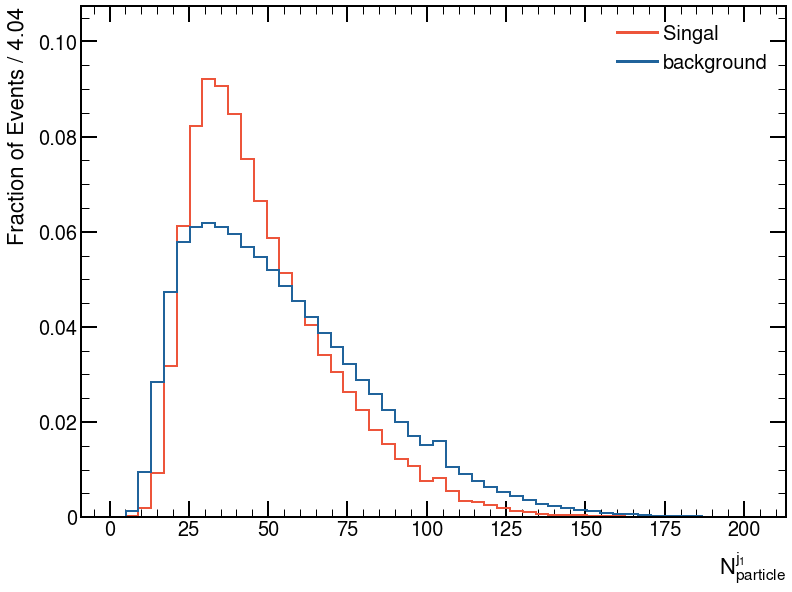

[INFO] Using deduced bin range (1.000, 196.000)


<Figure size 640x480 with 0 Axes>

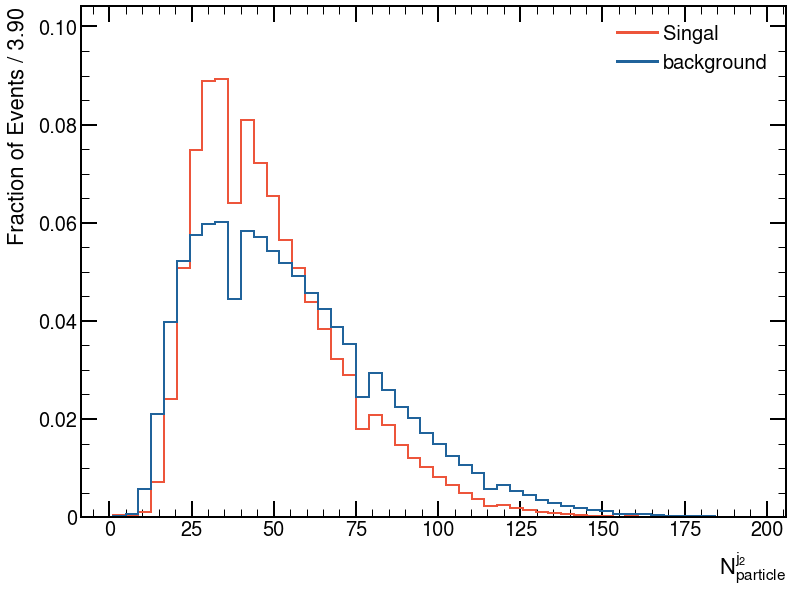

In [20]:
import matplotlib.pyplot as plt
options = {
    'mjj': {
        'xlabel': '$m_{jj} [GeV]$',
        'bin_range': (2000, 5000)
    },
    'lead_jet_pt': {
        'xlabel': '$p_T^{j_1} [GeV]$',
        'bin_range': (1200, 2600)
    },
    'sub_jet_pt': {
        'xlabel': '$p_T^{j_2} [GeV]$',
        'bin_range': (1200, 2600)
    },
    'lead_jet_m': {
        'xlabel': '$m^{j_1} [GeV]$',
        'bin_range': (0, 800)
    },
    'sub_jet_m': {
        'xlabel': '$m^{j_2} [GeV]$',
        'bin_range': (0, 800)
    },
    'lead_jet_eta': {
        'xlabel': '$\eta_{j_1}$'
    },
    'sub_jet_eta': {
        'xlabel': '$\eta_{j_2}$'
    },
    'lead_jet_phi': {
        'xlabel': '$\phi_{j_1}$'
    },
    'sub_jet_phi': {
        'xlabel': '$\phi_{j_2}$'
    },
    'lead_jet_N': {
        'xlabel': '$N_{particle}^{j_1}$'
    },
    'sub_jet_N': {
        'xlabel': '$N_{particle}^{j_2}$'
    }
}
label_map = {
    'signal'    : 'Singal',
    'bakcground': 'Background'
}
plotter = VariableDistributionPlot(dfs, label_map=label_map)
for column in options:
    plotter.draw(column,
                 **options[column],
                 bins=50,
                 normalize=True,
                 ypad=0.1)
    plt.show()

In [29]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from quickstats.plots import get_cmap
cmap_jet = get_cmap('jet')
cmap_jet.set_under('white')

def make_jet_image(features, title:str="jet", dimension:int=64,
                   xlabel:str="$\Delta \eta$", ylabel:str="$\Delta \phi$",
                   range=((-0.5, 0.5), (-0.5, 0.5)),
                   lognorm_range=(1e-4, 1),
                   cmap=cmap_jet):
    delta_eta = np.array(ak.flatten(features['part_delta_eta'], axis=None))
    delta_phi = np.array(ak.flatten(features['part_delta_phi'], axis=None))
    rel_pt = np.array(ak.flatten(features['part_rel_pt'], axis=None))
    hist2d, x_, y_ = np.histogram2d(delta_eta, 
                                    delta_phi,
                                    bins = (dimension, dimension),
                                    range=range,
                                    weights=rel_pt)
    # normalize the distribution
    hist2d_norm = hist2d / np.max(hist2d)
    vmin, vmax = lognorm_range
    fig, ax = plt.subplots(nrows=1, ncols=1)
    extend = np.array(range).flatten()
    handle = ax.imshow(hist2d_norm, cmap=cmap,
                       norm=LogNorm(vmin=vmin, vmax=vmax), extent=extend)
    fig.colorbar(handle, ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

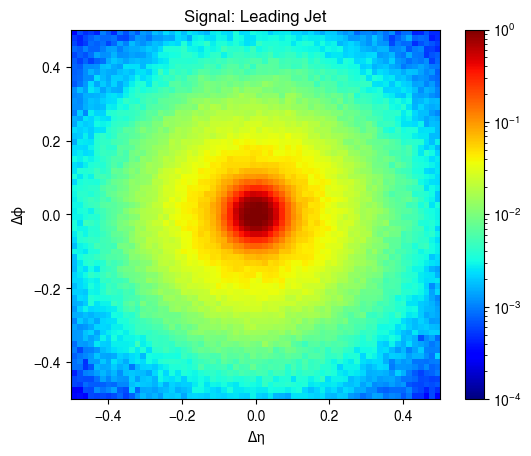

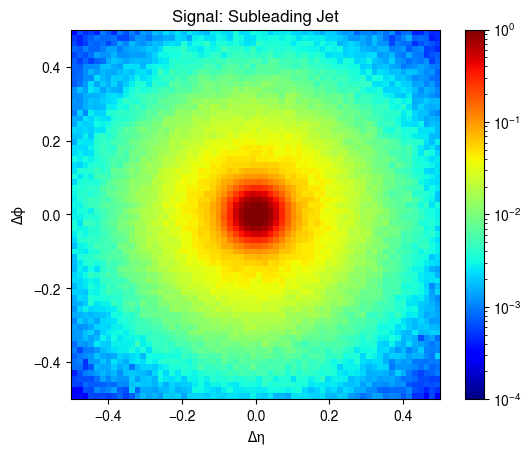

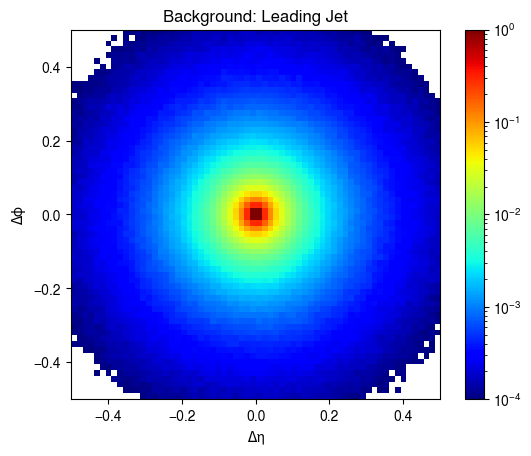

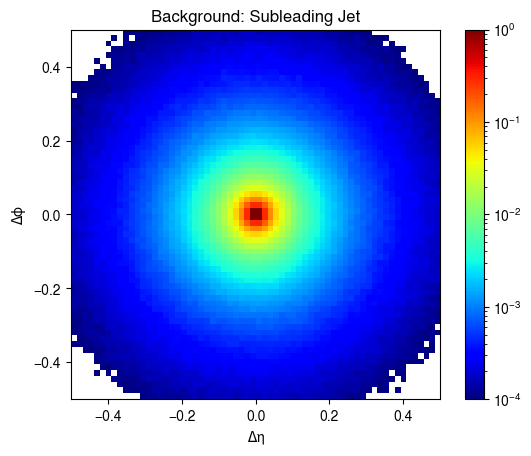

In [32]:
for dtype in ["signal", "background"]:
    for jtype, label in [("j1", "Leading Jet"), ("j2", "Subleading Jet")]:
        make_jet_image(features_array[dtype][jet_type], title = f"{dtype.title()}: {label}")
        plt.show()